In [11]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import ticker
from scipy.stats import norm
import os
pi = np.pi

In [12]:
# make grid of tangent projection centers - every 10 deg

alphasdeg = np.linspace(90,-90,19) # elevation
alphas = np.multiply(pi/180,alphasdeg)
thetasdeg = np.linspace(-180,180,36,endpoint=False)# azimuth
thetas = np.multiply(pi/180,thetasdeg)

# make local points and handle reprojection to different locations 

def makegrid(fovdeg=10,res=10,f=1.0):
    xlim = f*np.tan(fovdeg/2 * pi/180)
    xx,yy = np.meshgrid(np.linspace(-xlim,xlim,res),np.linspace(-xlim,xlim,res))
    return xx,yy

xx,yy = makegrid(fovdeg=10,res=10)
xx = np.ndarray.flatten(xx)
yy = np.ndarray.flatten(yy)

def pitch(a):
    return np.array([[1,0,0],[0,np.cos(a),np.sin(a)],[0,-np.sin(a),np.cos(a)]])

def yaw(a):
    return np.array([[np.cos(a),0,np.sin(a)],[0,1,0],[-np.sin(a),0,np.cos(a)]])

def roll(a):
    return np.array([[np.cos(a),-np.sin(a),0],[np.sin(a),np.cos(a),0],[0,0,1]])

def makeR(theta,alpha=0,gamma=0):
    return np.matmul(np.matmul(roll(gamma),pitch(alpha)),yaw(theta))

In [13]:
# create flows for different velocities and geometries

# geometries
def nearness_local(geometry='sphere',x=xx,y=yy,r=1,alpha=0):
    if geometry == 'sphere':
        mu = 1/r*np.sqrt(1-(x**2+y**2))
    elif geometry == 'floor':
        mu = np.abs(np.sin(alpha))/r * (alpha < 0)
    return mu

# flow from velocity
def getflow_local(Vx=0,Vy=0,Vz=0,Wx=0,Wy=0,Wz=0,
              geometry='sphere',r=1,f=1,
              x=xx,y=yy,theta=0,alpha=0):
    
    # rotate velocity to local patch
    V0 = [[Vx,Vy,Vz],[Wx,Wy,Wz]]
    R = makeR(theta,alpha)
    V = np.transpose(np.matmul(R,np.transpose(V0)))
    Vx,Vy,Vz = V[0]
    Wx,Wy,Wz = V[1]
    
    # get nearness
    mu = nearness_local(geometry=geometry,x=x,y=y,r=r,alpha=alpha)
    
    # compute local flow
    flow_horiz = -Vx*f*mu + Vz*mu*x - Wx*x*y/f + Wy*(f**2+x**2)/f - Wz*y
    flow_vert = -Vy*f*mu + Vz*mu*y - Wx*(f**2+y**2)/f + Wy*x*y/f + Wz*x
    
    return flow_horiz,flow_vert  

In [14]:
# predict self motion velocity from local flow patch
def getvel_local(flow,theta=0,alpha=0,x=xx,y=yy,geometry='sphere',DOFs=6,weights=np.ones_like(xx)):
    
    vxtemplate = np.ndarray.flatten(np.array(getflow_local(Vx=1,theta=theta,alpha=alpha,geometry=geometry,x=x,y=y)))
    vytemplate = np.ndarray.flatten(np.array(getflow_local(Vy=1,theta=theta,alpha=alpha,geometry=geometry,x=x,y=y)))
    vztemplate = np.ndarray.flatten(np.array(getflow_local(Vz=1,theta=theta,alpha=alpha,geometry=geometry,x=x,y=y)))
    wxtemplate = np.ndarray.flatten(np.array(getflow_local(Wx=1,theta=theta,alpha=alpha,geometry=geometry,x=x,y=y)))
    wytemplate = np.ndarray.flatten(np.array(getflow_local(Wy=1,theta=theta,alpha=alpha,geometry=geometry,x=x,y=y)))
    wztemplate = np.ndarray.flatten(np.array(getflow_local(Wz=1,theta=theta,alpha=alpha,geometry=geometry,x=x,y=y)))
    
    if DOFs == 1:
        templates = vztemplate
    elif DOFs == 3:
        templates = np.stack([vxtemplate,vztemplate,wytemplate])
    elif DOFs == 6:
        templates = np.stack([vxtemplate,vytemplate,vztemplate,wxtemplate,wytemplate,wztemplate])
    
    # remove locations where flow is missing
    weights = np.copy(weights)
    weights[np.isnan(flow[0])] = 0
    weights[np.isnan(flow[1])] = 0
    flow[0][np.isnan(flow[0])] = 0
    flow[1][np.isnan(flow[1])] = 0
    
    # weight template and sample
    template = np.transpose(templates*np.tile(weights,[DOFs,2]))
    sample = np.transpose(np.ndarray.flatten(np.array(flow))*np.tile(weights,[1,2]))
    
    # solve for self motion
    pred,_,_,_ = np.linalg.lstsq(template,sample,rcond=-1)
    return np.squeeze(pred)


# angle difference for heading error`
def anglediff(a,b,deg=False):
    if deg:
        return np.arctan2(np.sin((a-b)*np.pi/180),np.cos((a-b)*np.pi/180))*180/np.pi
    else:
        return np.arctan2(np.sin(a-b),np.cos(a-b))

In [15]:
# characterize local errors
def getlocalerrs(theta=0,alpha=0,
                 x=xx,y=yy,
                 trials=10000,
                 noiselevel=0.1,
                 spatvarnoise=False,
                 sparselevel=.25,
                 geometry='sphere',
                 DOFs=6,
                 plotit=False):

    #preds = np.nan*np.ones([trials,DOFs])
    #gt = np.nan*np.ones([trials,DOFs])
    errs = np.nan*np.ones([trials,DOFs+1])
    
    for i in range(trials): 
        
        # generate random behavior (uniform from -1 to 1)
        Vx,Vy,Vz,Wx,Wy,Wz = 2*np.random.rand(6) - 1
        if DOFs == 3:
            Vy = Wx = Wz = 0
        elif DOFs == 1:
            Vx = Vy = Wx = Wy = Wz = 0
            
        # create clean flow
        flow = getflow_local(geometry=geometry,theta=theta,alpha=alpha,x=x,y=y,
                         Vx=Vx,Vy=Vy,Vz=Vz,Wx=Wx,Wy=Wy,Wz=Wz)
        # add noise
        _,h = np.shape(flow)
        noise = noiselevel*np.random.randn(2*h)
        noise = np.reshape(noise,[2,h])
        if spatvarnoise:
            #noise = noise*(-(np.tile(y+alpha,[2,1])+np.pi/2)/(np.pi))
            noise = noise*((np.tile(-(y+alpha),[2,1])+np.pi/2)/(np.pi))
        flow = flow + noise

        # make sparse
        sparsity = np.random.rand(h)
        flow[0][sparsity<sparselevel] = np.nan
        flow[1][sparsity<sparselevel] = np.nan
        
        # optionally, plot flows
        if plotit == True:
            plt.quiver(x,y,flow[0],flow[1],scale=10,color='r')
            plt.xlim(-np.pi,np.pi)
            plt.ylim(-np.pi/2 - 0.25,np.pi/2 + 0.25)
            plt.savefig(f'./plots/example_local_flow_{i}.eps', format='eps')

        # get prediction and errors
        #preds[i,:] = getvel_local(flow,geometry=geometry,theta=theta,alpha=alpha,x=x,y=y,DOFs=DOFs)
        preds = getvel_local(flow,geometry=geometry,theta=theta,alpha=alpha,x=x,y=y,DOFs=DOFs)
        if DOFs == 3:
            #gt[i,:] = [Vx,Vz,Wy]
            gt =  [Vx,Vz,Wy]
        elif DOFs == 1:
            #gt[i,:] = [Vz]
            gt = [Vz]
        else:
            #gt[i,:] = [Vx,Vy,Vz,Wx,Wy,Wz]
            gt = [Vx,Vy,Vz,Wx,Wy,Wz]
        #errs[i,:DOFs] = preds[i,:]-gt[i,:]
        errs[i,:DOFs] = preds-gt
    
        # heading error
        if DOFs > 1:
            #headinggt = np.arctan2(gt[i,2],gt[i,0])
            headinggt = np.arctan2(gt[0],gt[2])
            #headingpred = np.arctan2(preds[i,2],preds[i,0])
            headingpred = np.arctan2(preds[0],preds[2])
            headingerr = anglediff(headingpred,headinggt,deg=False)
            errs[i,-1] = headingerr

    #return preds,gt,errs
    return errs

In [16]:
# run sim a bunch of times
def error_distribution(repeats=10,trials=10,noiselevel=0.05,sparselevel=.667,geometry='sphere',theta=thetas,alpha=alphas,DOFs=6,plotit=False,spatvarnoise=False):

    # initialize results        
    all_err         = np.zeros([repeats,7])

    for i in range(repeats):

        errs = getlocalerrs(theta=theta,alpha=alpha,
                                    trials=trials,
                                    noiselevel=noiselevel,
                                    spatvarnoise=spavarnoise,
                                    sparselevel=sparselevel,
                                    geometry=geometry,
                                    DOFs=behaviorDOFs)
        errs = np.nanmedian(np.abs(errs),axis=0)

        all_err[i,:] = errs
    return all_err


In [16]:
# calculate median error a bunch of times at best, worst, and middle patch for 6DOF sphere

geometry = 'sphere'
behaviorDOFs = 6
sparselevel = .667
noiselevel = .25
spavarnoise = False

trials=1000
repeats=1000

these_alphas = [0]
these_thetas = [0,np.pi/4,np.pi/2]


errs_best = error_distribution(repeats=repeats,trials=trials,noiselevel=noiselevel,
                                    sparselevel=sparselevel,
                                    geometry=geometry,
                                    theta=0,alpha=0,
                                    DOFs=behaviorDOFs,
                                    spatvarnoise=spavarnoise)

errs_worst = error_distribution(repeats=repeats,trials=trials,noiselevel=noiselevel,
                                    sparselevel=sparselevel,
                                    geometry=geometry,
                                    theta=np.pi/2,alpha=0,
                                    DOFs=behaviorDOFs,
                                    spatvarnoise=spavarnoise)

errs_middle = error_distribution(repeats=repeats,trials=trials,noiselevel=noiselevel,
                                    sparselevel=sparselevel,
                                    geometry=geometry,
                                    theta=np.pi/4,alpha=0,
                                    DOFs=behaviorDOFs,
                                    spatvarnoise=spavarnoise)

# convert to cm/s
errs_best = 100*errs_best
errs_worst = 100*errs_worst
errs_middle = 100*errs_middle

np.savez('./local_median_error_files/histogram_median_errors.npz',errs_best=errs_best,errs_worst=errs_worst,errs_middle=errs_middle)

#timestr = time.strftime("%Y%m%d-%H%M%S")
#outfile = f'{outdir}local_{sparselevel*100:.0f}pctsparse_{ntrials}trials_{noiselevel}noise_{geometry}_{behaviorDOFs}DOFs_{timestr}'
#np.savez(outfile,errs=errs)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


best min LOG ERROR 3.5517320248804722
worst max LOG ERROR 6.491610976535829
effect size (D) best to middle -64.82051121158027
effect size (D) worst to middle 9.211527038526688


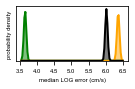

In [17]:
#Vz histograms

data = np.load('./local_median_error_files/histogram_median_errors.npz')
errs_best = data['errs_best']
errs_worst = data['errs_worst']
errs_middle = data['errs_middle']

errs_best = np.log(errs_best)
errs_worst = np.log(errs_worst)
errs_middle = np.log(errs_middle)

font = {'family' : 'arial',
         'size'   : 6}

matplotlib.rc('font', **font)

# bounds
print('best min LOG ERROR',np.min(errs_best[:,2]))
print('worst max LOG ERROR',np.max(errs_worst[:,2]))

xmin = np.min(errs_best[:,2])
xmax = np.max(errs_worst[:,2])
#xmin = 0
#xmax = 650
x = np.linspace(xmin, xmax, 100)

plt.figure(figsize=(2,1))

plt.hist(errs_best[:,2],bins=x,label='best',alpha=0.5,density=True,color='green')
mu_best, std_best = norm.fit(errs_best[:,2])
p = norm.pdf(x, mu_best, std_best)
plt.plot(x, p, 'green', linewidth=2)

plt.hist(errs_worst[:,2],bins=x,label='worst',alpha=0.5,density=True,color='orange')
mu_worst, std_worst = norm.fit(errs_worst[:,2])
p = norm.pdf(x, mu_worst, std_worst)
plt.plot(x, p, 'orange', linewidth=2)

plt.hist(errs_middle[:,2],bins=x,label='middle',alpha=0.5,density=True,color='black')
mu_middle, std_middle = norm.fit(errs_middle[:,2])
p = norm.pdf(x, mu_middle, std_middle)
plt.plot(x, p, 'black', linewidth=2)

#plt.legend(prop={'size': 6})
plt.xlabel('median LOG error (cm/s)')
plt.ylabel('probability density')
plt.yticks([])
plt.xticks([3.5,4,4.5,5,5.5,6,6.5])
#plt.legend()

# dprimes
print('effect size (D) best to middle',(mu_best-mu_middle)/np.sqrt((np.std(errs_best[:,2], ddof=1) ** 2 + np.std(errs_middle[:,2], ddof=1) ** 2) / 2.0) )
print('effect size (D) worst to middle',(mu_worst-mu_middle)/np.sqrt((np.std(errs_worst[:,2], ddof=1) ** 2 + np.std(errs_middle[:,2], ddof=1) ** 2) / 2.0) )

plt.savefig(f'./final_plots/final_fig1_local_histogram_Vz.png', format='png',dpi=300)
plt.savefig(f'./final_plots/final_fig1_local_histogram_Vz.eps', format='eps',dpi=300)

In [ ]:
# DEFUNCT

In [142]:
# run simulations and calculate distribution of errors - Vz

trials=1000
repeats=1000

inds = fullfield_inds
errors_fullfield = error_distribution(inds,repeats=repeats,trials=trials,noiselevel=0.25,geometry='sphere',theta=thetas,alpha=alphas,DOFs=6,spatvarnoise=False)
errors_fullfield = 100*errors_fullfield # convert to cm

inds = foci_inds
errors_foci = error_distribution(inds,repeats=repeats,trials=trials,noiselevel=0.25,geometry='sphere',theta=thetas,alpha=alphas,DOFs=6,spatvarnoise=False)
errors_foci = 100*errors_foci # convert to cm

inds = antifoci_inds
errors_antifoci = error_distribution(inds,repeats=repeats,trials=trials,noiselevel=0.25,geometry='sphere',theta=thetas,alpha=alphas,DOFs=6,spatvarnoise=False)
errors_antifoci = 100*errors_antifoci # convert to cm

full field mu =  2.091676648789718  std =  0.07639011187492362
foci mu =  2.5242201885642506  std =  0.09436960900549994
antifoci mu =  2.5242201885642506  std =  0.09436960900549994
effect size (D) anti to full -3.6720492367491695
effect size (D) foci to full 5.03573692625884


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

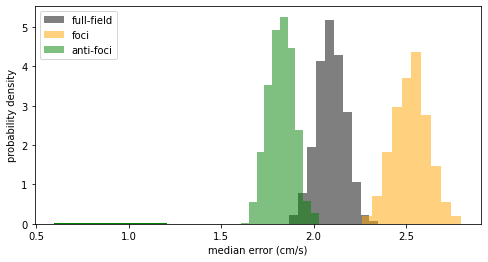

In [143]:
#Vz

plt.figure(figsize=(8,4))

xmin = 0.6
xmax = 1.2
x = np.linspace(xmin, xmax, 100)

plt.hist(errors_fullfield[:,5],label='full-field',alpha=0.5,density=True,color='k')
mu_fullfield, std_fullfield = norm.fit(errors_fullfield[:,5])
p = norm.pdf(x, mu_fullfield, std_fullfield)
plt.plot(x, p, 'k', linewidth=2)

print('full field mu = ',mu_fullfield,' std = ',std_fullfield)

plt.hist(errors_foci[:,5],label='foci',alpha=0.5,density=True,color='orange')
mu_foci, std_foci = norm.fit(errors_foci[:,5])
p = norm.pdf(x, mu_foci, std_foci)
plt.plot(x, p, 'orange', linewidth=2)
print('foci mu = ',mu_foci,' std = ',std_foci)

plt.hist(errors_antifoci[:,5],label='anti-foci',alpha=0.5,density=True,color='green')
mu_antifoci, std_antifoci = norm.fit(errors_antifoci[:,5])
p = norm.pdf(x, mu_antifoci, std_antifoci)
plt.plot(x, p, 'green', linewidth=2)
print('antifoci mu = ',mu_foci,' std = ',std_foci)

plt.legend(prop={'size': 10})
plt.xlabel('median error (cm/s)')
plt.ylabel('probability density')

# dprimes
print('effect size (D) anti to full',(mu_antifoci-mu_fullfield)/np.sqrt((np.std(errors_antifoci[:,5], ddof=1) ** 2 + np.std(errors_fullfield[:,5], ddof=1) ** 2) / 2.0) )
print('effect size (D) foci to full',(mu_foci-mu_fullfield)/np.sqrt((np.std(errors_foci[:,5], ddof=1) ** 2 + np.std(errors_fullfield[:,5], ddof=1) ** 2) / 2.0) )

plt.savefig(f'./global_plots/final_fig1_global_histogram_Vz.png', format='png',dpi=300)
plt.savefig(f'./global_plots/final_fig1_global_histogram_Vz.eps', format='eps',dpi=300)

In [146]:
# run simulations and calculate distribution of errors

trials=1000
repeats=1000

inds = fullfield_inds
heading_errors_fullfield = error_distribution(inds,repeats=repeats,trials=trials,noiselevel=0.25,geometry='sphere',theta=thetas,alpha=alphas,DOFs=6,spatvarnoise=False)
heading_errors_fullfield = (180/np.pi)*errors_fullfield # convert to deg

inds = heading_foci_inds
heading_errors_foci = error_distribution(inds,repeats=repeats,trials=trials,noiselevel=0.25,geometry='sphere',theta=thetas,alpha=alphas,DOFs=6,spatvarnoise=False)
heading_errors_foci = (180/np.pi)*errors_foci # convert to deg

inds = heading_antifoci_inds
heading_errors_antifoci = error_distribution(inds,repeats=repeats,trials=trials,noiselevel=0.25,geometry='sphere',theta=thetas,alpha=alphas,DOFs=6,spatvarnoise=False)
heading_errors_antifoci = (180/np.pi)*errors_antifoci # convert to cdeg

full field mu =  161.84895429164155  std =  6.3077688553317275
foci mu =  175.19272745714784  std =  6.6700929696088265
antifoci mu =  175.19272745714784  std =  6.6700929696088265
effect size (D) anti to full -92.07295930034721
effect size (D) foci to full 155.35021353038417


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

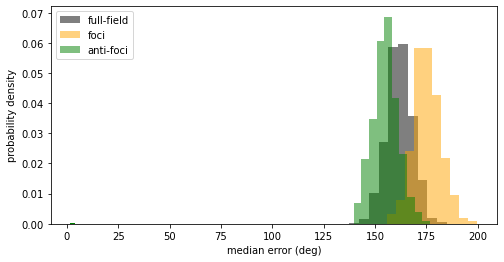

In [147]:
# heading
plt.figure(figsize=(8,4))

xmin = 2.0
xmax = 3.5
x = np.linspace(xmin, xmax, 100)

plt.hist(heading_errors_fullfield[:,6],label='full-field',alpha=0.5,density=True,color='k')
mu_fullfield, std_fullfield = norm.fit(heading_errors_fullfield[:,6])
p = norm.pdf(x, mu_fullfield, std_fullfield)
plt.plot(x, p, 'k', linewidth=2)

print('full field mu = ',mu_fullfield,' std = ',std_fullfield)

plt.hist(heading_errors_foci[:,6],label='foci',alpha=0.5,density=True,color='orange')
mu_foci, std_foci = norm.fit(heading_errors_foci[:,6])
p = norm.pdf(x, mu_foci, std_foci)
plt.plot(x, p, 'orange', linewidth=2)
print('foci mu = ',mu_foci,' std = ',std_foci)

plt.hist(heading_errors_antifoci[:,6],label='anti-foci',alpha=0.5,density=True,color='green')
mu_antifoci, std_antifoci = norm.fit(heading_errors_antifoci[:,6])
p = norm.pdf(x, mu_antifoci, std_antifoci)
plt.plot(x, p, 'green', linewidth=2)
print('antifoci mu = ',mu_foci,' std = ',std_foci)

plt.legend(prop={'size': 10})
plt.xlabel('median error (deg)')
plt.ylabel('probability density')

# dprimes
print('effect size (D) anti to full',(mu_antifoci-mu_fullfield)/np.sqrt((np.std(errors_antifoci[:,5], ddof=1) ** 2 + np.std(errors_fullfield[:,5], ddof=1) ** 2) / 2.0) )
print('effect size (D) foci to full',(mu_foci-mu_fullfield)/np.sqrt((np.std(errors_foci[:,5], ddof=1) ** 2 + np.std(errors_fullfield[:,5], ddof=1) ** 2) / 2.0) )

plt.savefig(f'./global_plots/final_fig1_global_histogram_heading.png', format='png',dpi=300)
plt.savefig(f'./global_plots/final_fig1_global_histogram_heading.eps', format='eps',dpi=300)